# Keras 101: Designing your Neural Network - How Many Hidden Layers?

Hopefully you will have followed our walkthrough on the affect of adding more neurons to a single hidden layers.

We stared with the simpliest componant of a neural network the neuron and demonstrated how this describes a linear classifier (Logistic regression). We then saw that for each neuron added to a single hidden layer a new linear representation of your input data can be used in the final output of the neural network. As such with an arbitary number of neurons any continuous function can be approximated, in terms of our classification example this meant that any arbitary decision boundary could be drawn.

At this point a question you may be asking yourself "if a single hidden layer with an arbitary number of neurons can approximate any continuous function, why might we add a second hidden layer?" In reality it is rare to find a problem that requires more than a single hidden layer, ...give some examples... however there are situations in which it is certainly benifitial or even impracticle not to.

In order to begin exploring the effects of more hidden layers we are going to look at a different type of problem know as regression. We are going to build a neural network that aims to learn some complex functions, specifically variations of a 2D gaussian.

# Data Generation

To start we need to import the necessary packages and define a couple of useful functions.

In [29]:
import keras
import numpy as np
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gkern2(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    guass = fi.gaussian_filter(inp, nsig)/kernlen
    max1 = np.amax(guass)
    gauss = guass/max1
    return gauss

def generateGaussianHill(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = gkern2(spacer,sig)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacer)
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def generateGaussianHillValley(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = np.append(gkern2(spacer,9),-1*gkern2(spacer,9),axis=0)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/(2*spacer))
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def plotGaussian(ax,labels,xmin,xmax,ymin,ymax,spacerx,spacery,title):
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacerx)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacery)
    X, Y = np.meshgrid(x, y)
    gaus = labels.reshape(X.shape)
    ax.autoscale(enable=True, axis='both', tight=None)
    ax.plot_surface(X, Y, gaus)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

def plotHeatMap(ax,model,xmin,xmax,ymin,ymax,title):
    xx, yy = np.meshgrid(np.arange(xmin,xmax,0.1),np.arange(ymin,ymax,0.1))
    ax.contourf(xx,yy,model.reshape(xx.shape))
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)

def lossPlot(loss,label):
    
    epoch = np.arange(0, len(loss))
    plt.plot(epoch,loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


For this first example we will be attempting to produce a neural netowrk that aims to approximate a 2d gaussian. Our training data and a plot of our target function can be found by running the code below.

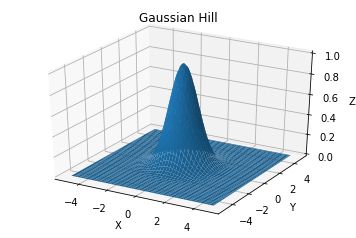

In [2]:
features, labels = generateGaussianHill(-5.0,5.0,-5.0,5.0,100,9)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotGaussian(ax,labels,-5.0,5.0,-5.0,5.0,100,100,"Gaussian Hill")
plt.show()

In order to learn this function we will input each x and y co-ordinate into the network, the output of the network will be the z height for that pair of x and y co-ordinates. Therefor our features array will consist of an array of x and y co-ordiantes and our labels array will correspond to the z height for each x and y pair.

# Single Hidden Layer Test

We will repeat our experiment from the previous notebook for this dataset. We will build a number of neural networks with incresing number of neurons in a single hidden layer. When we run this code a summary of each network will be output, note the number of parameters for each network.

In [36]:
layers = []
layers.append(keras.layers.Dense(5, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model1 = keras.Sequential(layers)
print(model1.summary())

layers = []
layers.append(keras.layers.Dense(15, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model2 = keras.Sequential(layers)
print(model2.summary())

layers = []
layers.append(keras.layers.Dense(45, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model3 = keras.Sequential(layers)
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 15)                45        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 16        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (t

Let's now train each network and plot the log of the loss against training epoch for each model.

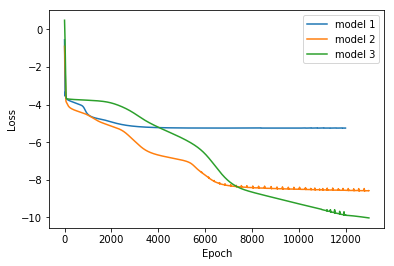

Final Loss for model3 4.428443207871169e-05


In [37]:
model1.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history1 = model1.fit(features, labels, batch_size=features.shape[0],epochs=8000, verbose=0)
model2.compile(optimizer=keras.optimizers.Adam(lr=0.003), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history2 = model2.fit(features, labels, batch_size=features.shape[0],epochs=14000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history3 = model3.fit(features, labels, batch_size=features.shape[0],epochs=12000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history4 = model3.fit(features, labels, batch_size=features.shape[0],epochs=1000, verbose=0)

history3 = history3.history['loss'] + history4.history['loss']

lossPlot(np.log(history1.history['loss']),"model 1")
lossPlot(np.log(history2.history['loss']),"model 2")
lossPlot(np.log(history3),"model 3")
plt.show()
print("Final Loss for model3", history3[-1])

We can see that increasing the number of neurons drastically reduces the final loss of the model. Let's have a look at how close each network is to reproducing the target function.

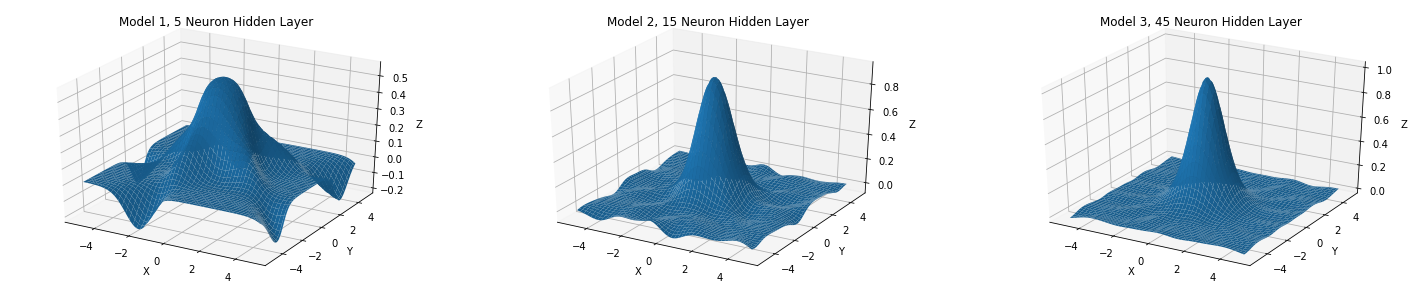

In [38]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(131, projection='3d')
z = model1.predict(features)
plotGaussian(ax,z,-5.0,5.0,-5.0,5.0,100,100,"Model 1, 5 Neuron Hidden Layer")
z = model2.predict(features)
ax = fig.add_subplot(132, projection='3d')
plotGaussian(ax,z,-5.0,5.0,-5.0,5.0,100,100,"Model 2, 15 Neuron Hidden Layer")
z = model3.predict(features)
ax = fig.add_subplot(133, projection='3d')
plotGaussian(ax,z,-5.0,5.0,-5.0,5.0,100,100,"Model 3, 45 Neuron Hidden Layer")
plt.show()

It is clear that increasing the number of neurons drastically brings the learnt function closer to the target. Interestingly it takes reletively few neurons to reproduce the signiture bump in the target function however smoothing the flat surounding area requires a relatively large number of neurons.

For us an interesting number to take note of is the number of parameters in the network, for a single hidden layer of 45 neurons there are 181 parameters in the network or 181 weights to be calculated for each iteration in the network.

# Two Hidden Layer Test

Now let's take a look at a neural network model with two hidden layers that contains much fewer neurons in each layer than the previous examples, the first contains 3 and the second contains 2. 

In [39]:
layers = []
layers.append(keras.layers.Dense(3, input_dim = 2, activation="sigmoid"))
layers.append(keras.layers.Dense(2, activation="sigmoid"))

layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 3         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
None


We can now train this model and plot the loss to check for convergence.

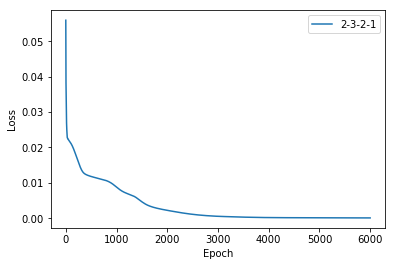

Final Loss: 8.632420212961733e-05


In [40]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history2 = model.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)

lossPlot(history.history['loss']+history2.history['loss'],"2-3-2-1")
plt.show()
print("Final Loss:",history2.history['loss'][-1])


Finally we shall plot the resulting function the network has learnt.

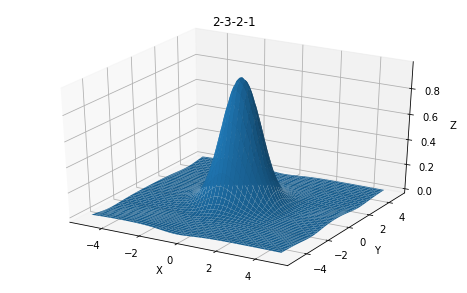

In [41]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
z = model.predict(features)
plotGaussian(ax,z,-5.0,5.0,-5.0,5.0,100,100,'2-3-2-1')
plt.show()

As you can see the output function of this network already better resembles the target function with a lower loss and a smoother flat area surrounding the bump compared with those single hidden layer examples. You may also have noted that the number of parameters int his network (20) is much less than that of the network with many neurons and a single hidden layer.

Here we have demonstrated the first benifit of adding more hidden layers to your nerual network, a second hidden layer allows you to solve highly non-linear problems with relatively few parameters compared with a single hidden layer network that requires a large number of neurons for comparable performance.

To further illustrate this point is a table generated from running a large number of networks where the number of neurons in both first and second hidden layers have been varied, with the first column representing the results of just a single hidden layer. The first number on each box describes the total number of parameter in the network and the number in brackets represents the loss (the colour also signifies the loss). 

There are a couple of points we can make about this table. Firstly we can confirm our initial statement that with a second hidden layer we can produce a comparable network with far less parameters. The second point to make here is that the final loss of the network is much lower for those networks with a significant number of neurons in the second hidden layer, however it must be stated that for a practicle problem this may result in overfitting and is therfore not the only metric that a network should be judged on. The third point to make is that with a single neuron in the first hidden layer they're is no benifit of adding more neurons in the second hidden layer (we will return to this point later).

# What is Happening?

In order to better understand the effect of a second hidden layer we are going to take a look at the output of each neuron in the network previously trained (two hidden layers of 3 and 2 neurons respectively). Below is a plot of the output from each neuron when all the training data has been feed through so that we can see how each neuron contributes to the output of the network. The two segments of code below produce two different perspectives of the outputs from each neuron, the first generates a 3d projection of the inputs (x and y) and the corresponding output for those inputs (z). The second segment generates a top down heatmap where the outout (z) is represented by the color of each point on the graph.

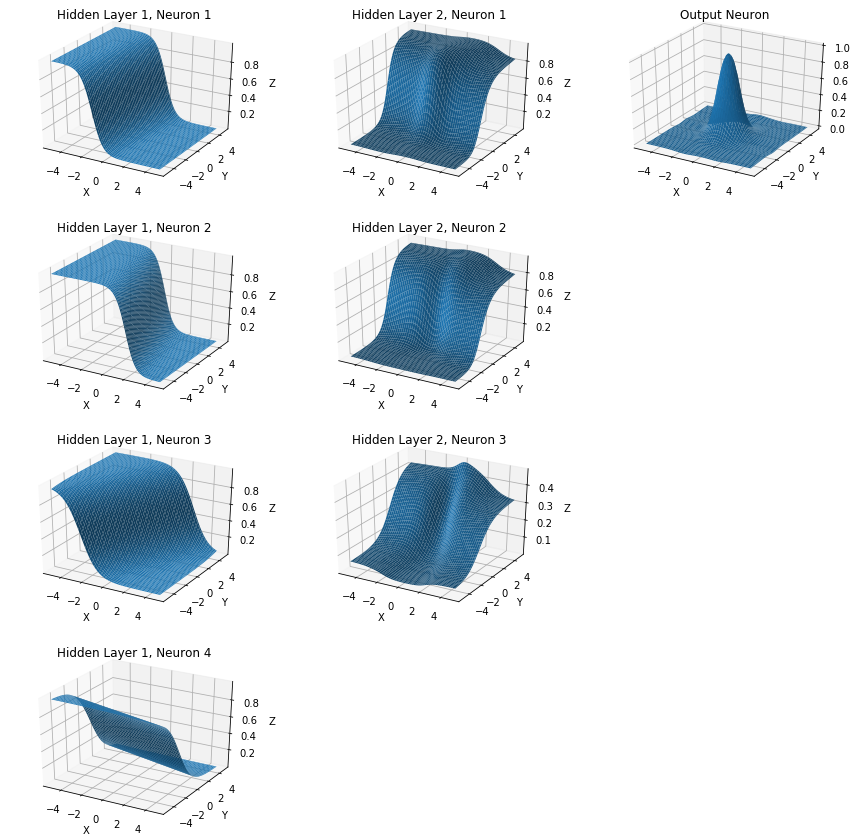

In [31]:
Hidden_layer_output = keras.backend.function([model.layers[0].input],[model.layers[0].output])
out = Hidden_layer_output([features])[0]

out1 = out[:,[0]]
out2 = out[:,[1]]
out3 = out[:,[2]]
out4 = out[:,[3]]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(431, projection='3d')
plotGaussian(ax,out1,-5.0,5.0,-5.0,5.0,100,100,"Hidden Layer 1, Neuron 1")
ax = fig.add_subplot(434, projection='3d')
plotGaussian(ax,out2,-5.0,5.0,-5.0,5.0,100,100,"Hidden Layer 1, Neuron 2")
ax = fig.add_subplot(437, projection='3d')
plotGaussian(ax,out3,-5.0,5.0,-5.0,5.0,100,100,"Hidden Layer 1, Neuron 3")
ax = fig.add_subplot(4,3,10, projection='3d')
plotGaussian(ax,out4,-5.0,5.0,-5.0,5.0,100,100,"Hidden Layer 1, Neuron 4")

Hidden_layer_output = keras.backend.function([model.layers[1].input],[model.layers[1].output])
out = Hidden_layer_output([out])[0]

out1 = out[:,[0]]
out2 = out[:,[1]]
out3 = out[:,[2]]

ax = fig.add_subplot(432, projection='3d')
plotGaussian(ax,out1,-5.0,5.0,-5.0,5.0,100,100,"Hidden Layer 2, Neuron 1")
ax = fig.add_subplot(435, projection='3d')
plotGaussian(ax,out2,-5.0,5.0,-5.0,5.0,100,100,"Hidden Layer 2, Neuron 2")
ax = fig.add_subplot(438, projection='3d')
plotGaussian(ax,out3,-5.0,5.0,-5.0,5.0,100,100,"Hidden Layer 2, Neuron 3")

Hidden_layer_output = keras.backend.function([model.layers[2].input],[model.layers[2].output])
out = Hidden_layer_output([out])[0]

out1 = out[:,[0]]
ax = fig.add_subplot(433, projection='3d')
plotGaussian(ax,out1,-5.0,5.0,-5.0,5.0,100,100,"Output Neuron")
plt.show()


(10000, 1)


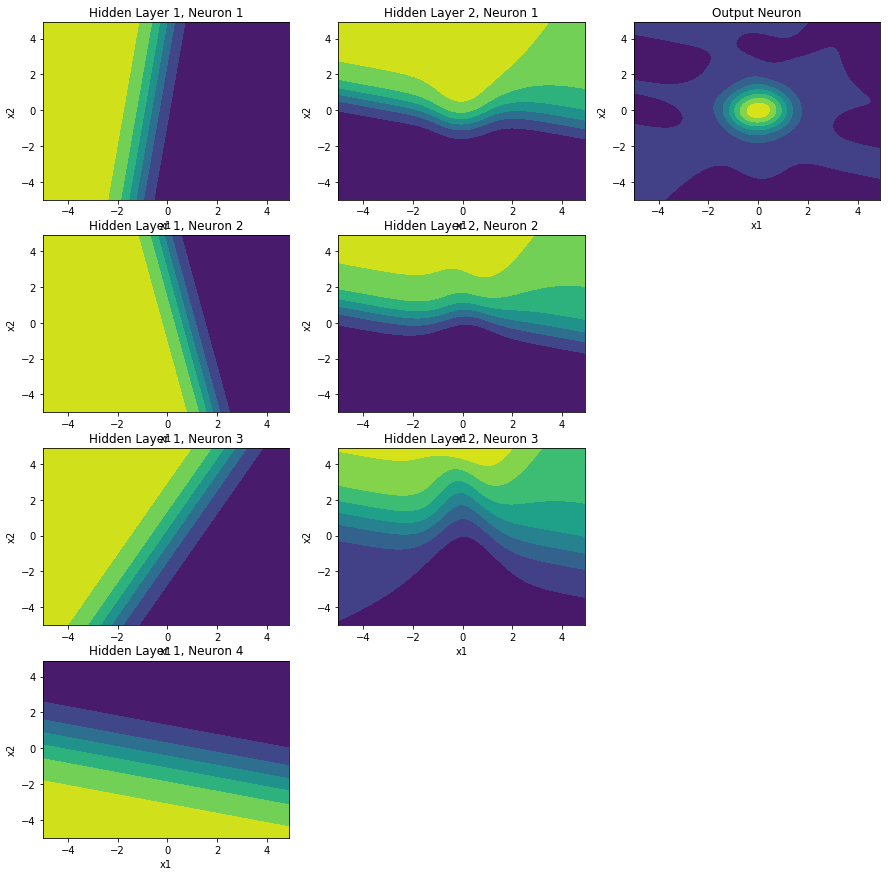

In [30]:
Hidden_layer_output = keras.backend.function([model.layers[0].input],[model.layers[0].output])
out = Hidden_layer_output([features])[0]

out1 = out[:,[0]]
out2 = out[:,[1]]
out3 = out[:,[2]]
out4 = out[:,[3]]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(431)
print(out1.shape)

plotHeatMap(ax,out1,-5.0,5.0,-5.0,5.0,"Hidden Layer 1, Neuron 1")

ax = fig.add_subplot(434)
plotHeatMap(ax,out2,-5.0,5.0,-5.0,5.0,"Hidden Layer 1, Neuron 2")

ax = fig.add_subplot(437)
plotHeatMap(ax,out3,-5.0,5.0,-5.0,5.0,"Hidden Layer 1, Neuron 3")

ax = fig.add_subplot(4,3,10)
plotHeatMap(ax,out4,-5.0,5.0,-5.0,5.0,"Hidden Layer 1, Neuron 4")

Hidden_layer_output = keras.backend.function([model.layers[1].input],[model.layers[1].output])
out = Hidden_layer_output([out])[0]

out1 = out[:,[0]]
out2 = out[:,[1]]
out3 = out[:,[2]]

ax = fig.add_subplot(432)
plotHeatMap(ax,out1,-5.0,5.0,-5.0,5.0,"Hidden Layer 2, Neuron 1")
ax = fig.add_subplot(435)
plotHeatMap(ax,out2,-5.0,5.0,-5.0,5.0,"Hidden Layer 2, Neuron 2")
ax = fig.add_subplot(438)
plotHeatMap(ax,out3,-5.0,5.0,-5.0,5.0,"Hidden Layer 2, Neuron 3")

Hidden_layer_output = keras.backend.function([model.layers[2].input],[model.layers[2].output])
out = Hidden_layer_output([out])[0]

out1 = out[:,[0]]
ax = fig.add_subplot(433)
plotHeatMap(ax,out1,-5.0,5.0,-5.0,5.0,"Output Neuron")
plt.show()


Let's examine the output of the first hidden layer (the first column in the above plot). This shape may look familiar to you, it is the shape of a smooth 2D step function derived from our choice of a sigmoid activation function. Each neuron acts as a logistic regression unit that outputs a value (z) based off the weighted linear combination of inputs (x and y), as this is a linear combination of inputs x and y the shape of the surface at each value of z is linear. The different weights learnt for each neuron result in a range of sigmoid shapped functions with different gradients and orientations.

Each neuron in the second layer (second column in the above plot) represents a weighted linear combination of the step functions output from the first layer, passing this combination through the sigmoid function of each neuron in the second layer results in a complex surface that consists of many hills and vallys constructed from the smooth step functions in the previous layer. The result is a complex relationship between the inputs into the network (x and y) and the output of those neurons. Multiple neurons in this second hidden layer result in many complex mappings of input to output.  

The final output neuron (final column in the above plot) is again a linear weighted combination of the complex surfaces in the previous layer allowing for the final gaussian hill to be generated with very few neurons.

I'd like to return to a point previously made, "with a single neuron in the first hidden layer they're is no benifit in adding more neurons in the second hidden layer". If we consider how we have just deconstructed each layer in the network then this statment should make sense, since with a single neruron in the first hiddden layer we have only a single logistic reggression unit, each subsequent neuron in the second hidden layer has only a single input mapping onto a single output.

# How Deep Should We Go?

We have seen that adding a second hidden layer results in a network that can produce a complex mapping of input to output with very few neurons. The question now is "Why not add many more hidden layers to our network?", it turns out that for more than 2 or 3 densly connected layers it becomes increasingly difficult to train the network. A phenomenon known as the vanishing gradient problem comes into play. This will be the subject of the next notebook.

(300, 2)
(1200,)


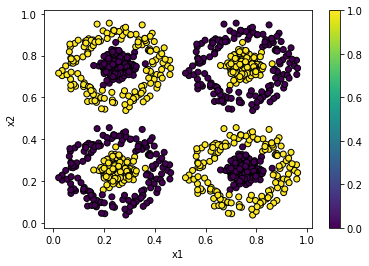

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


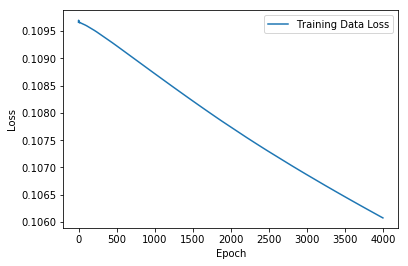

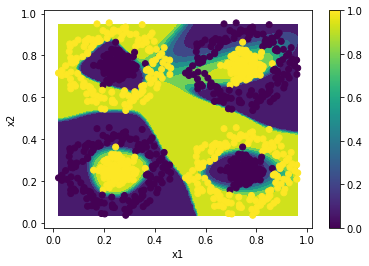

In [10]:
from sklearn.datasets import make_moons, make_circles

dataset_circle = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle1 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle2 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle3 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)

features_circle = dataset_circle[0]
labels_circle = dataset_circle[1]
labels_circle1 =labels_circle.copy()

features_circle[:,0] = (features_circle[:,0]+1.5)/6.0
features_circle[:,1] = (features_circle[:,1]+1.5)/6.0

features_circle2 = features_circle.copy()
features_circle2[:,0] = features_circle[:,0]+0.5

oneFilter = labels_circle ==1
zeroFilter = labels_circle ==0
labels_circle2 = labels_circle.copy()
labels_circle2[oneFilter] = 0
labels_circle2[zeroFilter] = 1


features_circle3 = features_circle.copy()
features_circle3[:,1] = features_circle[:,1]+0.5

features_circle4 = features_circle.copy()
features_circle4[:,1] = features_circle[:,1]+0.5
features_circle4[:,0] = features_circle[:,0]+0.5



print(features_circle.shape)
features_circle = np.append(features_circle,features_circle2, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle3, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle4, axis=0)
labels_circle = np.append(labels_circle,labels_circle1, axis=0)
print(labels_circle.shape)

x1_min = np.amin(features_circle[:,0])
x1_max = np.amax(features_circle[:,0])
x2_min = np.amin(features_circle[:,1])
x2_max = np.amax(features_circle[:,1])

plt.scatter(features_circle[:,0],features_circle[:,1],edgecolor="black",linewidth=1,c=labels_circle)
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()


layers = []
layers.append(keras.layers.Dense(10, input_dim = 2, activation="sigmoid"))

layers.append(keras.layers.Dense(1, activation="sigmoid"))

model = keras.Sequential(layers)
print(model.summary())
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features_circle, labels_circle, batch_size=features_circle.shape[0],epochs=18000, verbose=0)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features_circle, labels_circle, batch_size=features_circle.shape[0],epochs=4000, verbose=0)

loss = history.history['loss']
epoch = np.arange(0, len(loss))

plt.plot(epoch,loss, label='Training Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
xx, yy = np.meshgrid(np.arange(x1_min,x1_max,0.01),np.arange(x2_min,x2_max,0.01))

z = model.predict(np.c_[xx.ravel(),yy.ravel()])
z = z.reshape(xx.shape)

plt.contourf(xx,yy,z)
plt.scatter(features_circle[:,0],features_circle[:,1],c= labels_circle)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()